In [1]:
# IMPORT LIBRARY
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time

Using TensorFlow backend.


In [2]:
# IMAGES PATH
dataset_path = '../data/ENZ_crop/'
# CSV PATH
df = pd.read_csv('../data/data_618_final.csv')

# CHANGE COLUMN NAME
df['Depth(km)'] = df['Depth']
df.drop('Depth',axis=1,inplace=True)
df['foldername'] = df['filename'].apply(lambda x: x+'crop')

df

,Unnamed: 0,No,filename,Date,Hr,Min,Sec,Lat,Long,Mag,...,PA_start_real,flag_start,PA_start,datetime,seconds,time,foldername,PA,cluster_class,Depth(km)
0,0,0,20090118_064750,18/01/2009,6,47,50,-9.13465,114.535,4.6,...,194,269,275,00:15.5,15.510,15.510,20090118_064750crop,200,5,54.570
1,1,1,20090119_171408,19/01/2009,17,14,9,-8.89110,111.814,3.1,...,200,275,275,00:17.0,16.970,16.970,20090119_171408crop,200,3,36.888
2,2,2,20090119_211141,19/01/2009,21,11,41,-8.62730,113.663,3.9,...,200,275,275,00:14.9,14.946,14.946,20090119_211141crop,200,13,92.661
3,3,3,20090120_123437,20/01/2009,12,34,34,-10.61305,114.893,4.9,...,197,272,275,00:33.7,33.725,33.575,20090120_123437crop,197,5,55.502
4,4,4,20090120_134800,20/01/2009,13,47,57,-10.56872,114.862,3.7,...,200,275,275,00:33.2,33.156,33.156,20090120_134800crop,200,5,43.658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613,663,712,20170818_084429,18/08/2017,8,44,29,-11.35369,112.160,4.6,...,200,275,275,00:49.4,49.359,49.359,20170818_084429crop,200,7,66.033
614,664,713,20170824_053322,24/08/2017,5,33,22,-9.35305,112.741,3.6,...,198,273,275,00:21.4,21.440,21.440,20170824_053322crop,200,0,7.439
615,665,714,20170901_034735,1/9/2017,3,47,35,-11.35750,112.808,4.7,...,200,275,275,00:49.5,49.533,49.533,20170901_034735crop,200,7,61.404
616,666,715,20170910_044804,10/9/2017,4,48,4,-7.04644,114.197,3.3,...,200,275,275,00:23.0,22.998,22.998,20170910_044804crop,200,4,10.067


(616, 423, 3)
(256, 192, 3)


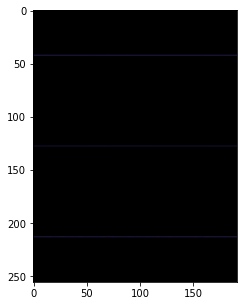

In [6]:
import cv2
import matplotlib.pyplot as plt

# GET IMAGE SIZE FROM DATASET
img = load_img(dataset_path+'20170428_014929crop/'+'000000_20170428_014929_crop.png')
x = img_to_array(img)
print(x.shape)
plt.figure(figsize=(5,5))
x = cv2.resize(x, (192, 256))
print(x.shape)
plt.imshow(x/255)

In [7]:
### GET DATA FROM FOLDER
all_images = []
list_folder_in_df = [fd for fd in os.listdir(dataset_path) if fd in df.foldername.values]
print('Jumlah folder:',len(os.listdir(dataset_path)),', irisan jumlah folder dengan dataframe:',len(list_folder_in_df))
df = df[df.foldername.isin(list_folder_in_df)]

Jumlah folder: 671 , irisan jumlah folder dengan dataframe: 618


In [8]:
df.head()

,Unnamed: 0,No,filename,Date,Hr,Min,Sec,Lat,Long,Mag,...,PA_start_real,flag_start,PA_start,datetime,seconds,time,foldername,PA,cluster_class,Depth(km)
0,0,0,20090118_064750,18/01/2009,6,47,50,-9.13465,114.535,4.6,...,194,269,275,00:15.5,15.510,15.510,20090118_064750crop,200,5,54.570
1,1,1,20090119_171408,19/01/2009,17,14,9,-8.89110,111.814,3.1,...,200,275,275,00:17.0,16.970,16.970,20090119_171408crop,200,3,36.888
2,2,2,20090119_211141,19/01/2009,21,11,41,-8.62730,113.663,3.9,...,200,275,275,00:14.9,14.946,14.946,20090119_211141crop,200,13,92.661
3,3,3,20090120_123437,20/01/2009,12,34,34,-10.61305,114.893,4.9,...,197,272,275,00:33.7,33.725,33.575,20090120_123437crop,197,5,55.502
4,4,4,20090120_134800,20/01/2009,13,47,57,-10.56872,114.862,3.7,...,200,275,275,00:33.2,33.156,33.156,20090120_134800crop,200,5,43.658


## Train Test Split

In [10]:
test_df = pd.read_csv('../data/data_test_val_final2.csv')
test_df = test_df[test_df.foldername.isin(df.foldername.values)]
train_df = df[~df.foldername.isin(test_df.foldername.values)]

list_folder_for_train = [__ for __ in train_df.foldername.values]
list_folder_for_validation = [__ for __ in test_df.foldername.values]
list_folder_for_test = list_folder_for_validation

print()
print('Pembagian Dataset:')
print('TRAIN:',len(list_folder_for_train))
print('VALIDATION:',len(list_folder_for_validation))
print('TEST:',len(list_folder_for_test))


Pembagian Dataset:
TRAIN: 556
VALIDATION: 62
TEST: 62


In [12]:
## CHECK THE REDUNDANT
for __ in list_folder_for_train:
    if __ in  list_folder_for_test+list_folder_for_validation:
        print(__)

## Select Data Label

In [14]:
## GET IMAGE NAMES FROM FOLDER

PA_start = 5
PA_end = 6

NonPA_times = 20
NonPA_start = -200
NonPA_end = 100

NonPA_times_close = 4
NonPA_start_close = -17 
NonPA_end_close = -1

NonPA_times_close2 = 40
NonPA_start_close2 = 100
NonPA_end_close2 = 200

train_images = []
for fol in list_folder_for_train:
    PA_real = int(df[df.foldername==fol].PA_start_real.values)
    for img in os.listdir(dataset_path+fol):
        if len(img)>2 and (int(img[:6]) in range(PA_real+(int(PA_start*20)),PA_real+(int(PA_end*20))+1)):
            train_images += [(fol,img,1)]
        elif len(img)>2 and (int(img[:6]) in range(PA_real+(int(PA_start*20))+NonPA_start_close,PA_real+(int(PA_start*20))+NonPA_end_close+1,NonPA_times_close)):
            train_images += [(fol,img,0)]
        elif len(img)>2 and (int(img[:6]) in range(PA_real+(int(PA_start*20))+NonPA_start_close2,PA_real+(int(PA_start*20))+NonPA_end_close2+1,NonPA_times_close2)):
            train_images += [(fol,img,0)]
        elif len(img)>2 and int(img[:6]) in range(PA_real+(int(PA_start*20))+NonPA_start,PA_real+(int(PA_start*20))+NonPA_end,NonPA_times):
            train_images += [(fol,img,0)]
   

validation_images = []
for fol in list_folder_for_validation:
    PA_real = int(df[df.foldername==fol].PA_start_real.values)
    for img in os.listdir(dataset_path+fol):
        if len(img)>2 and int(img[:6]) in range(PA_real+(int(PA_start*20)),PA_real+(int(PA_end*20))+1):
            validation_images += [(fol,img,1)]
        elif len(img)>2 and (int(img[:6]) in range(PA_real+(int(PA_start*20))+NonPA_start_close,PA_real+(int(PA_start*20))+NonPA_end_close+1,NonPA_times_close)):
            validation_images += [(fol,img,0)]
        elif len(img)>2 and (int(img[:6]) in range(PA_real+(int(PA_start*20))+NonPA_start_close2,PA_real+(int(PA_start*20))+NonPA_end_close2+1,NonPA_times_close2)):
            validation_images += [(fol,img,0)]
            
        elif len(img)>2 and int(img[:6]) in range(PA_real+(int(PA_start*20))+NonPA_start,PA_real+(int(PA_start*20))+NonPA_end,NonPA_times):
            validation_images += [(fol,img,0)]
            

test_images = []
for fol in list_folder_for_test:
    PA_real = int(df[df.foldername==fol].PA_start_real.values)
    for img in os.listdir(dataset_path+fol):
        if len(img)>2 and int(img[:6]) in range(PA_real+(int(PA_start*20)),PA_real+(int(PA_end*20))+1):
            test_images += [(fol,img,1)]
        elif len(img)>2 and (int(img[:6]) in range(PA_real+(int(PA_start*20))+NonPA_start_close,PA_real+(int(PA_start*20))+NonPA_end_close+1,NonPA_times_close)):
            test_images += [(fol,img,0)]
        elif len(img)>2 and (int(img[:6]) in range(PA_real+(int(PA_start*20))+NonPA_start_close2,PA_real+(int(PA_start*20))+NonPA_end_close2+1,NonPA_times_close2)):
            test_images += [(fol,img,0)] 
        elif len(img)>2 and int(img[:6]) in range(PA_real+(int(PA_start*20))+NonPA_start,PA_real+(int(PA_start*20))+NonPA_end,NonPA_times):
            test_images += [(fol,img,0)]

print('train_images',len(train_images))
print('validation_images',len(validation_images))
print('test_images',len(test_images))

train_images 23311
validation_images 2604
test_images 2604


In [15]:
print('Number of train label 0:', len([a for a,b,c in train_images if c == 0]))
print('Number of train label 1:', len([a for a,b,c in train_images if c == 1]))

print('Number of validation label 0:', len([a for a,b,c in validation_images if c == 0]))
print('Number of validation label 1:', len([a for a,b,c in validation_images if c == 1]))

print('Number of test label 0:', len([a for a,b,c in test_images if c == 0]))
print('Number of test label 1:', len([a for a,b,c in test_images if c == 1]))

Jumlah Train kelas 0: 11635
Jumlah Train kelas 1: 11676
Jumlah Validation kelas 0: 1302
Jumlah Validation kelas 1: 1302
Jumlah Test kelas 0: 1302
Jumlah Test kelas 1: 1302


In [16]:
### LOAD IMAGE AND LABEL DATA

def load_data(images_data,source_path,shuffle=False):
    train_data = np.zeros([len(images_data),x.shape[0],x.shape[1],3]) 
    y = np.zeros([len(images_data),1])
    
    img_ids = np.arange(len(images_data))

    if shuffle:
        np.random.shuffle(img_ids)

    for i in img_ids:
        image_path = source_path + images_data[i][0] + '/' + images_data[i][1] 
        image = cv2.imread(image_path, 1) 
        b,g,r = cv2.split(image) 
        image = cv2.merge([r,g,b]) 
        image = cv2.resize(image, (x.shape[1], x.shape[0]))
        image = image/255.0 
        
        train_data[i,:,:,:] = image
        y[i,:] = images_data[i][2]

    return train_data,y.astype(int),img_ids


In [17]:
X_train,y_train,img_train_ids = load_data(train_images,dataset_path,True)
print('Train data has been loaded')
X_valid,y_valid,img_valid_ids = load_data(validation_images,dataset_path)
print('Validation data has been loaded')
X_test,y_test,img_test_ids = load_data(test_images,dataset_path)
print('Test data has been loaaded')

Train data has been loaded
Validation data has been loaded
Test data has been loaaded


In [18]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
print('Train IDS:',img_train_ids[:10]) 

(23311, 256, 192, 3)
(2604, 256, 192, 3)
(2604, 256, 192, 3)
[ 8107 20857  1496 17892  8755   978  1032  7843 13150 15906]


##### MODELING

In [19]:
# DEFINE CUSTOM NAME (name is given manually after the model name and PA position)
custom_name = "ENZ_final_all_ep50_batch4_#1"

In [20]:
# ADDITIONAL METRIC FUNCTIONS
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [21]:
from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

from keras.models import *
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam

# MODEL BUILD FUNCTION
def make_model(base="", custom_name=custom_name):
    m_ = None
    model_name = base.upper() + "_parival_"  
    model_name = model_name + "-".join([str(PA_start),str(PA_end)])

    if base.lower()=="cnn":
        ### FOR CNN MODELS ###

        base_model = Sequential()
        base_model.add(Conv2D(32, (3, 3), input_shape=(x.shape[0], x.shape[1], 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(64, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(128, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Conv2D(256, (3, 3)))
        base_model.add(BatchNormalization())
        base_model.add(Activation('relu'))
        base_model.add(MaxPooling2D(pool_size=(2, 2)))

        base_model.add(Flatten()) 
        base_model.add(Dense(1024))
        base_model.add(Activation('relu'))
        base_model.add(Dense(512))
        base_model.add(Activation('relu'))
        base_model.add(Dense(128))
        base_model.add(Activation('relu'))
        m_ = base_model.output

        ### --------------- ###

    elif base.lower()=="mobilenetv3":
        ### FOR MOBILENETV3 ###

        import keras
        from keras.applications import keras_applications
        from keras_applications.mobilenet_v3 import MobileNetV3Large, MobileNetV3Small

        base_model = MobileNetV3Large(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet', backend=keras.backend, layers=keras.layers, models=keras.models, utils=keras.utils) #RGB 3, grayscale 1

        # RENAME LAYER TO SOLVE THE PROBLEM WHEN SAVING THE MODEL
        for i, layer in enumerate(base_model.layers[1:]):
            layer.name = 'layer_' + str(i) + '_' + layer.name

        m_ = base_model.output

        m_ = GlobalAveragePooling2D()(m_)
        m_ = Dense(1024,activation='relu')(m_) #we add dense layers so that the model can learn more complex functions and classify for better results.
        m_ = Dense(512,activation='relu')(m_) #dense layer 2
        m_ = Dense(256,activation='relu')(m_) #dense layer 3
        
        ### --------------- ###
    elif base.lower()[:-1]=="efficientnetb":
        ### FOR EFFICIENTNET ###
        import keras
        from efficientnet.keras import EfficientNetB0,EfficientNetB1
        from efficientnet.keras import EfficientNetB2,EfficientNetB3
        from efficientnet.keras import EfficientNetB4,EfficientNetB5

        EFMODEL = {}
        EFMODEL['efficientnetb0'] = EfficientNetB0(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb1'] = EfficientNetB1(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb2'] = EfficientNetB2(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb3'] = EfficientNetB3(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb4'] = EfficientNetB4(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1
        EFMODEL['efficientnetb5'] = EfficientNetB5(input_shape=(x.shape[0], x.shape[1], 3), include_top=False, weights='imagenet') #RGB 3, grayscale 1

        base_model = EFMODEL[base.lower()]
        # RENAME LAYER TO SOLVE THE PROBLEM WHEN SAVING THE MODEL
        for i, layer in enumerate(base_model.layers[1:]):
            layer.name = 'layer_' + str(i) + '_' + layer.name

        m_ = base_model.output

        m_ = GlobalAveragePooling2D()(m_)
        m_ = Dense(1024,activation='relu')(m_) #we add dense layers so that the model can learn more complex functions and classify for better results.
        m_ = Dense(512,activation='relu')(m_) #dense layer 2
        m_ = Dense(256,activation='relu')(m_) #dense layer 3
        
        ### --------------- ###
    else:
        print("Model Definition Error")
    
    outputs = Dense(1, activation = 'sigmoid')(m_) #final layer with sigmoid activation
        
    model = Model(inputs=base_model.input, outputs=outputs) 
    
    model.compile(optimizer=Adam(1e-4),
                  loss="binary_crossentropy",   
                  metrics=["accuracy",f1_m,precision_m, recall_m])
    
    model.name = model_name if custom_name is "" else model_name + "_" + custom_name
    
    return model


In [22]:
## CREATE DIRECTORY MODEL SAVE
model_save_path = "./models/EXPERIMENT_001/"
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

In [23]:
## DEFINE NSTEP=EPOCHS AND NBATCH=BATCH_SIZE AND MODEL_CHECKPOINT_MONITOR_AND_MODE
NSTEP = 50
NBATCH = 4
BestSave = {'monitor':'val_f1_m','mode':'max'}

In [24]:
folder_list = list_folder_for_test
print('Num of test event:',len(folder_list))
ncheck = 5

Jumlah folder test: 62


In [25]:
## TESTING FUNCTION
def prediction_final(ncheck, folder_list, model):
#     %%time
    pred_images_start = [] 
    pred_images_end = [] 

    ncheck = ncheck

    for _im,folder in enumerate(folder_list):
        directory = dataset_path+folder+'/'
        predicted_label = []
        print(_im,'Predicting',folder,'with',len([img for img in os.listdir(directory) if len(img)>2]),'images', end=' ')
        flag = np.zeros([ncheck])
        i = 0
        nothing = True
        for filename in [img for img in os.listdir(directory) if len(img)>2]:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                start_time = time.time()
                img = image.load_img(directory+filename, target_size=(x.shape[0], x.shape[1]))
                img = image.img_to_array(img)
                img = np.expand_dims(img, axis=0)/255

                images = np.vstack([img])
                classes = model.predict(images)
                predicted_label.append(classes[0][0])

                if int(filename[:6])%1000==0:
                    print('.', end=' ')

                if float(classes[0][0]) > 0.5: 
                    flag[i] = 1
                    i += 1
                    if sum(flag) == ncheck:
                        print('')
                        pred_images_start.append(int(str(filename)[:6])-(ncheck-1))
                        pred_images_end.append(int(str(filename)[:6]))
                        print('-->',int(str(filename)[:6])-(ncheck-1),'({})'.format(filename[:-4]))                             
                        nothing = False
                        print()
                        break
                else:
                    flag = np.zeros([ncheck])
                    i = 0
        if nothing:
            pred_images_start.append(np.nan)
            pred_images_end.append(np.nan)  
            
                
    return pred_images_start,pred_images_end

## Training

# CNN

In [26]:
#build model
model = make_model(base="cnn")
output_names = ["loss","accuracy","f1_m","precision_m", "recall_m"]
model.name

'CNN_parival_5-6_ENZ_final_all_ep50_batch4_#1'

In [27]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = NBATCH

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.00001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor=BestSave['monitor'], mode=BestSave['mode'])

In [28]:
#training the model
history = model.fit(X_train, y_train, 
        validation_data = (X_valid, y_valid),
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[checkpoint,swa])

Train on 23311 samples, validate on 2604 samples
Epoch 1/50
23311/23311 [==============================] - 338s 14ms/step - loss: 0.2290 - accuracy: 0.9119 - f1_m: 0.8424 - precision_m: 0.8478 - recall_m: 0.8662 - val_loss: 0.1383 - val_accuracy: 0.9412 - val_f1_m: 0.5219 - val_precision_m: 0.5113 - val_recall_m: 0.5471

Epoch 00001: val_f1_m improved from -inf to 0.52191, saving model to ./models/21-11-2020/CNN_parival_5-6_ENZ_final_all_ep50_batch4_#1/CNN_parival_5-6_ENZ_final_all_ep50_batch4_#1_best.h5
Epoch 2/50
23311/23311 [==============================] - 276s 12ms/step - loss: 0.1293 - accuracy: 0.9507 - f1_m: 0.8841 - precision_m: 0.8852 - recall_m: 0.8998 - val_loss: 0.1018 - val_accuracy: 0.9535 - val_f1_m: 0.5275 - val_precision_m: 0.5276 - val_recall_m: 0.5402

Epoch 00002: val_f1_m improved from 0.52191 to 0.52749, saving model to ./models/21-11-2020/CNN_parival_5-6_ENZ_final_all_ep50_batch4_#1/CNN_parival_5-6_ENZ_final_all_ep50_batch4_#1_best.h5
Epoch 3/50
23311/23311 [==

23311/23311 [==============================] - 239s 10ms/step - loss: 1.0131e-11 - accuracy: 1.0000 - f1_m: 0.9417 - precision_m: 0.9417 - recall_m: 0.9417 - val_loss: 2.7284 - val_accuracy: 0.9589 - val_f1_m: 0.5295 - val_precision_m: 0.5321 - val_recall_m: 0.5374

Epoch 00047: val_f1_m did not improve from 0.53574
Epoch 48/50
23311/23311 [==============================] - 237s 10ms/step - loss: 1.7553e-11 - accuracy: 1.0000 - f1_m: 0.9348 - precision_m: 0.9348 - recall_m: 0.9348 - val_loss: 2.5892 - val_accuracy: 0.9589 - val_f1_m: 0.5294 - val_precision_m: 0.5321 - val_recall_m: 0.5374

Epoch 00048: val_f1_m did not improve from 0.53574
Epoch 49/50
23311/23311 [==============================] - 237s 10ms/step - loss: 6.6660e-11 - accuracy: 1.0000 - f1_m: 0.9384 - precision_m: 0.9384 - recall_m: 0.9384 - val_loss: 2.5960 - val_accuracy: 0.9581 - val_f1_m: 0.5290 - val_precision_m: 0.5321 - val_recall_m: 0.5366

Epoch 00049: val_f1_m did not improve from 0.53574
Epoch 50/50
23311/2331

In [29]:
#save model after training (SWA weights)
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

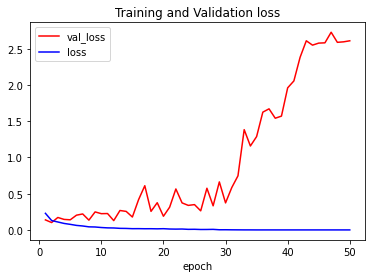

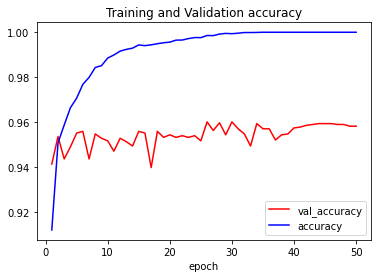

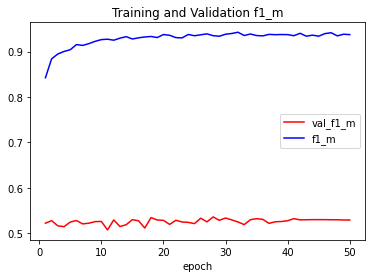

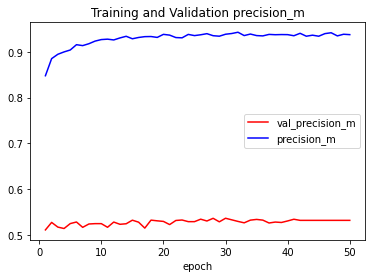

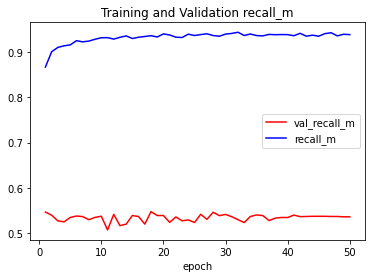

In [30]:
import matplotlib.pyplot as plt

import pickle
with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)

#plot training validation process from history.bin
for output_name in output_names:
    val_y = history.history["val_"+output_name]
    train_y = history.history[output_name]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label="val_"+output_name)
    plt.plot(epochs, train_y, color="blue", label=output_name)
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation {}".format(output_name))
    plt.savefig(model_save_path + model.name + "/" + model.name + "_" + output_name + "_training_plot.jpg")
    plt.show()

### Test  Predict (Best)

In [31]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

with open(model_save_path + model.name + "/" + model.name + '_scores_best.txt', 'w') as f:
    for eval_result,col_result in zip(test_eval,output_names):
        text_to_write = col_result+" : "+str(eval_result)
        f.write(text_to_write+"\n")
        print(text_to_write)

2604/2604 [==============================] - 20s 8ms/step
loss : 0.33248822809783374
accuracy : 0.9596773982048035
f1_m : 0.5357398986816406
precision_m : 0.5366103053092957
recall_m : 0.5467230081558228


In [32]:
for check in range(1,ncheck+1):
    ### Predict
    print('###',check,'###')
    pred_images_start,pred_images_end = prediction_final(check,folder_list,model) # Fungsi Prediction Final

    ### Save CSV 
    df_save = pd.DataFrame({'filename':[_.replace('crop','') for _ in folder_list]})
    df_save['flag_start'] = pred_images_start
    df_save['flag_end'] = pred_images_end
    df_save['second_start'] = df_save.apply(lambda x: round((x['flag_start']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save['second_end'] = df_save.apply(lambda x: round((x['flag_end']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save.to_csv(model_save_path+model.name+'/Hasil_test_PA_{}-{}_Check{}_best.csv'.format(PA_start,PA_end,check),index=False)

### 1 ###
0 Predicting 20160307_152953crop with 801 images . 
--> 300 (000300_20160307_152953_crop)

1 Predicting 20160222_202028crop with 801 images . 
--> 299 (000299_20160222_202028_crop)

2 Predicting 20110313_041920crop with 801 images . 
--> 302 (000302_20110313_041920_crop)

3 Predicting 20120216_205331crop with 801 images . 
--> 292 (000292_20120216_205331_crop)

4 Predicting 20151022_182326crop with 801 images . 
--> 12 (000012_20151022_182326_crop)

5 Predicting 20160712_193858crop with 801 images . 
--> 302 (000302_20160712_193858_crop)

6 Predicting 20170926_013646crop with 801 images . 
--> 299 (000299_20170926_013646_crop)

7 Predicting 20170128_092836crop with 801 images . 
--> 225 (000225_20170128_092836_crop)

8 Predicting 20170428_014929crop with 801 images . 
--> 301 (000301_20170428_014929_crop)

9 Predicting 20111127_064316crop with 801 images . 
--> 298 (000298_20111127_064316_crop)

10 Predicting 20120122_101453crop with 801 images . 
--> 289 (000289_20120122_101

54 Predicting 20121001_015724crop with 801 images . 
--> 300 (000302_20121001_015724_crop)

55 Predicting 20121216_162427crop with 801 images . 
--> 300 (000302_20121216_162427_crop)

56 Predicting 20131023_004226crop with 800 images . 
--> 298 (000300_20131023_004226_crop)

57 Predicting 20160322_000705crop with 801 images . 
--> 293 (000295_20160322_000705_crop)

58 Predicting 20160907_130216crop with 801 images . 
--> 280 (000282_20160907_130216_crop)

59 Predicting 20160912_103821crop with 801 images . 
--> 300 (000302_20160912_103821_crop)

60 Predicting 20150922_035018crop with 801 images . 
--> 302 (000304_20150922_035018_crop)

61 Predicting 20100209_003925crop with 801 images . 
--> 299 (000301_20100209_003925_crop)

### 4 ###
0 Predicting 20160307_152953crop with 801 images . 
--> 300 (000303_20160307_152953_crop)

1 Predicting 20160222_202028crop with 801 images . 
--> 303 (000306_20160222_202028_crop)

2 Predicting 20110313_041920crop with 801 images . 
--> 302 (000305_2011

### Test  Predict (SWA)

In [33]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

with open(model_save_path + model.name + "/" + model.name + '_scores_swa.txt', 'w') as f:
    for eval_result,col_result in zip(test_eval,output_names):
        text_to_write = col_result+" : "+str(eval_result)
        f.write(text_to_write+"\n")
        print(text_to_write)

2604/2604 [==============================] - 9s 3ms/step
loss : 2.4593354810171655
accuracy : 0.9589093923568726
f1_m : 0.5295150279998779
precision_m : 0.5321300625801086
recall_m : 0.5373784303665161


In [34]:
for check in range(1,ncheck+1):
    ### Predict
    print('###',check,'###')
    pred_images_start,pred_images_end = prediction_final(check,folder_list,model) # Fungsi Prediction Final

    ### Save CSV 
    df_save = pd.DataFrame({'filename':[_.replace('crop','') for _ in folder_list]})
    df_save['flag_start'] = pred_images_start
    df_save['flag_end'] = pred_images_end
    df_save['second_start'] = df_save.apply(lambda x: round((x['flag_start']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save['second_end'] = df_save.apply(lambda x: round((x['flag_end']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save.to_csv(model_save_path+model.name+'/Hasil_test_PA_{}-{}_Check{}_swa.csv'.format(PA_start,PA_end,check),index=False)

### 1 ###
0 Predicting 20160307_152953crop with 801 images . 
--> 301 (000301_20160307_152953_crop)

1 Predicting 20160222_202028crop with 801 images . 
--> 299 (000299_20160222_202028_crop)

2 Predicting 20110313_041920crop with 801 images . 
--> 302 (000302_20110313_041920_crop)

3 Predicting 20120216_205331crop with 801 images . 
--> 293 (000293_20120216_205331_crop)

4 Predicting 20151022_182326crop with 801 images . 
--> 301 (000301_20151022_182326_crop)

5 Predicting 20160712_193858crop with 801 images . 
--> 301 (000301_20160712_193858_crop)

6 Predicting 20170926_013646crop with 801 images . 
--> 299 (000299_20170926_013646_crop)

7 Predicting 20170128_092836crop with 801 images . 
--> 226 (000226_20170128_092836_crop)

8 Predicting 20170428_014929crop with 801 images . 
--> 304 (000304_20170428_014929_crop)

9 Predicting 20111127_064316crop with 801 images . 
--> 299 (000299_20111127_064316_crop)

10 Predicting 20120122_101453crop with 801 images . 
--> 290 (000290_20120122_10

54 Predicting 20121001_015724crop with 801 images . 
--> 300 (000302_20121001_015724_crop)

55 Predicting 20121216_162427crop with 801 images . 
--> 300 (000302_20121216_162427_crop)

56 Predicting 20131023_004226crop with 800 images . 
--> 298 (000300_20131023_004226_crop)

57 Predicting 20160322_000705crop with 801 images . 
--> 293 (000295_20160322_000705_crop)

58 Predicting 20160907_130216crop with 801 images . 
--> 280 (000282_20160907_130216_crop)

59 Predicting 20160912_103821crop with 801 images . 
--> 301 (000303_20160912_103821_crop)

60 Predicting 20150922_035018crop with 801 images . 
--> 302 (000304_20150922_035018_crop)

61 Predicting 20100209_003925crop with 801 images . 
--> 299 (000301_20100209_003925_crop)

### 4 ###
0 Predicting 20160307_152953crop with 801 images . 
--> 301 (000304_20160307_152953_crop)

1 Predicting 20160222_202028crop with 801 images . 
--> 303 (000306_20160222_202028_crop)

2 Predicting 20110313_041920crop with 801 images . 
--> 302 (000305_2011

# MobileNetV3

In [ ]:
#build model
model = make_model(base="mobilenetv3")
output_names = ["loss","accuracy","f1_m","precision_m", "recall_m"]
model.name

In [ ]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = NBATCH

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.00001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor=BestSave['monitor'], mode=BestSave['mode'])

In [ ]:
#training the model
history = model.fit(X_train, y_train, 
        validation_data = (X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint,swa])

In [ ]:
#save model after training (SWA weights)
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

In [ ]:
import matplotlib.pyplot as plt

import pickle
with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)
    
#plot training validation process from history.bin
for output_name in output_names:
    val_y = history.history["val_"+output_name]
    train_y = history.history[output_name]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label="val_"+output_name)
    plt.plot(epochs, train_y, color="blue", label=output_name)
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation {}".format(output_name))
    plt.savefig(model_save_path + model.name + "/" + model.name + "_" + output_name + "_training_plot.jpg")
    plt.show()

### Test  Predict (Best)

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

with open(model_save_path + model.name + "/" + model.name + '_scores_best.txt', 'w') as f:
    for eval_result,col_result in zip(test_eval,output_names):
        text_to_write = col_result+" : "+str(eval_result)
        f.write(text_to_write+"\n")
        print(text_to_write)

In [ ]:
for check in range(1,ncheck+1):
    ### Predict
    print('###',check,'###')
    pred_images_start,pred_images_end = prediction_final(check,folder_list,model) # Fungsi Prediction Final

    ### Save CSV 
    df_save = pd.DataFrame({'filename':[_.replace('crop','') for _ in folder_list]})
    df_save['flag_start'] = pred_images_start
    df_save['flag_end'] = pred_images_end
    df_save['second_start'] = df_save.apply(lambda x: round((x['flag_start']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save['second_end'] = df_save.apply(lambda x: round((x['flag_end']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save.to_csv(model_save_path+model.name+'/Hasil_test_PA_{}-{}_Check{}_best.csv'.format(PA_start,PA_end,check),index=False)

### Test  Predict (SWA)

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

with open(model_save_path + model.name + "/" + model.name + '_scores_swa.txt', 'w') as f:
    for eval_result,col_result in zip(test_eval,output_names):
        text_to_write = col_result+" : "+str(eval_result)
        f.write(text_to_write+"\n")
        print(text_to_write)

In [ ]:
for check in range(1,ncheck+1):
    ### Predict
    print('###',check,'###')
    pred_images_start,pred_images_end = prediction_final(check,folder_list,model) # Fungsi Prediction Final

    ### Save CSV 
    df_save = pd.DataFrame({'filename':[_.replace('crop','') for _ in folder_list]})
    df_save['flag_start'] = pred_images_start
    df_save['flag_end'] = pred_images_end
    df_save['second_start'] = df_save.apply(lambda x: round((x['flag_start']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save['second_end'] = df_save.apply(lambda x: round((x['flag_end']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save.to_csv(model_save_path+model.name+'/Hasil_test_PA_{}-{}_Check{}_SWA.csv'.format(PA_start,PA_end,check),index=False)

# EfficientNetB

In [ ]:
#build model
model = make_model(base="efficientnetb5")
output_names = ["loss","accuracy","f1_m","precision_m", "recall_m"]
model.name

In [ ]:
from swa.tfkeras import SWA

#set the hyperparams
epochs = NSTEP
batch_size = int(NBATCH//4)

#make model folder save
if not os.path.exists(model_save_path + model.name):
    os.mkdir(model_save_path + model.name)

#add callback
swa = SWA(start_epoch=epochs-int(epochs*0.2), 
              lr_schedule='constant',
              swa_lr=0.00001,
              verbose=1)
checkpoint = ModelCheckpoint(model_save_path + model.name + "/" + model.name + "_best.h5", save_weights_only=True,
                             verbose=1, save_best_only=True, monitor=BestSave['monitor'], mode=BestSave['mode'])

In [ ]:
#training the model
history = model.fit(X_train, y_train, 
        validation_data = (X_valid, y_valid),
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[checkpoint,swa])

In [ ]:
#save model after training (SWA weights)
model.save_weights(model_save_path + model.name + "/" + model.name+"_SWA.h5")

In [ ]:
import matplotlib.pyplot as plt

import pickle
with open(model_save_path + model.name + "/" +'history.bin', 'wb') as handle:
    pickle.dump(model.history.history, handle)

#plot training validation process from history.bin
for output_name in output_names:
    val_y = history.history["val_"+output_name]
    train_y = history.history[output_name]
    epochs = range(1, len(val_y) + 1)

    plt.figure()
    plt.plot(epochs, val_y, color="red", label="val_"+output_name)
    plt.plot(epochs, train_y, color="blue", label=output_name)
    plt.legend()
    plt.xlabel("epoch")
    plt.title("Training and Validation {}".format(output_name))
    plt.savefig(model_save_path + model.name + "/" + model.name + "_" + output_name + "_training_plot.jpg")
    plt.show()

### Test  Predict (Best)

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_best.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

with open(model_save_path + model.name + "/" + model.name + '_scores_best.txt', 'w') as f:
    for eval_result,col_result in zip(test_eval,output_names):
        text_to_write = col_result+" : "+str(eval_result)
        f.write(text_to_write+"\n")
        print(text_to_write)

In [ ]:
for check in [1,2,3,4,5,10]:
    ### Predict
    print('###',check,'###')
    pred_images_start,pred_images_end = prediction_final(check,folder_list,model) # Fungsi Prediction Final

    ### Save CSV 
    df_save = pd.DataFrame({'filename':[_.replace('crop','') for _ in folder_list]})
    df_save['flag_start'] = pred_images_start
    df_save['flag_end'] = pred_images_end
    df_save['second_start'] = df_save.apply(lambda x: round((x['flag_start']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save['second_end'] = df_save.apply(lambda x: round((x['flag_end']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save.to_csv(model_save_path+model.name+'/Hasil_test_PA_{}-{}_Check{}_best.csv'.format(PA_start,PA_end,check),index=False)

### Test  Predict (SWA)

In [ ]:
model.load_weights(model_save_path + model.name + "/" + model.name + "_SWA.h5")
test_eval = model.evaluate(X_test, y_test, batch_size=batch_size)

with open(model_save_path + model.name + "/" + model.name + '_scores_swa.txt', 'w') as f:
    for eval_result,col_result in zip(test_eval,output_names):
        text_to_write = col_result+" : "+str(eval_result)
        f.write(text_to_write+"\n")
        print(text_to_write)

In [ ]:
for check in [1,2,3,4,5,10]:
    ### Predict
    print('###',check,'###')
    pred_images_start,pred_images_end = prediction_final(check,folder_list,model) # Fungsi Prediction Final

    ### Save CSV 
    df_save = pd.DataFrame({'filename':[_.replace('crop','') for _ in folder_list]})
    df_save['flag_start'] = pred_images_start
    df_save['flag_end'] = pred_images_end
    df_save['second_start'] = df_save.apply(lambda x: round((x['flag_start']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save['second_end'] = df_save.apply(lambda x: round((x['flag_end']-(int(df[df.filename==x['filename']].PA_start_real.values)+(PA_start*20)))*0.05,2),axis=1)
    df_save.to_csv(model_save_path+model.name+'/Hasil_test_PA_{}-{}_Check{}_SWA.csv'.format(PA_start,PA_end,check),index=False)